1. Add one histogram with the discriminator in the root file which we have. for all regions
2. Add it to trees as well.
3. 
Follow the same structure

Deadline: Jul 29, 2024

In [ ]:
## Load the saved model 

In [1]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

import os
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# file path
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GJetPt40/preselection")
]
keys = [
#     'dibjet_mass',
    # 'diphoton_mass',
    'bbgg_mass',
    'dibjet_pt',
    'diphoton_pt',
    'bbgg_pt',
    # 'lead_pho_pt',
    # 'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    # 'lead_pt_over_diphoton_mass',
    # 'sublead_pt_over_diphoton_mass',
    # 'lead_pt_over_dibjet_mass',
    # 'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
    # 'weight_preselection',
    'weight_preselection',
]

In [3]:
dfs = {}

# Loop through each file and load the corresponding dataframe
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(keys, library="pd")

signal_df = dfs["/GluGluToHH/preselection"]
background_df_1 = dfs["/GGJets/preselection"]
background_df_2 = dfs["/GJetPt20To40/preselection"]
background_df_3 = dfs["/GJetPt40/preselection"]

print('singal df', signal_df.shape)
print('background_df_1 ', background_df_1.shape)
print('background_df_2', background_df_2.shape)
print('background_df_3 ', background_df_3.shape)

background_df = pd.concat([background_df_1, background_df_2, background_df_3], ignore_index=True)
print('background_df', background_df.shape)

signal_df['label'] = 1
background_df['label'] = 0

combined_df = pd.concat([signal_df, background_df], ignore_index=True)
print('combined dataframe', combined_df.shape)

features = [
    # 'diphoton_mass',
#     'dibjet_mass',
    # 'lead_pho_pt',
    # 'sublead_pho_pt',
    'bbgg_eta',
    'bbgg_phi',
    'bbgg_mass',
    'lead_pho_eta',
    'lead_pho_phi',
    'sublead_pho_eta',
    'sublead_pho_phi',
    'diphoton_eta',
    'diphoton_phi',
    'dibjet_eta',
    'dibjet_phi',
    'lead_bjet_pt',
    'sublead_bjet_pt',
    'lead_bjet_eta',
    'lead_bjet_phi',
    'sublead_bjet_eta',
    'sublead_bjet_phi',
    'sublead_bjet_PNetB',
    'lead_bjet_PNetB',
    'CosThetaStar_gg',
    'CosThetaStar_jj',
    'CosThetaStar_CS',
    'DeltaR_jg_min',
    'pholead_PtOverM',
    'phosublead_PtOverM',
    'FirstJet_PtOverM',
    'SecondJet_PtOverM',
    # 'lead_pt_over_diphoton_mass',
    # 'sublead_pt_over_diphoton_mass',
    # 'lead_pt_over_dibjet_mass',
    # 'sublead_pt_over_dibjet_mass',
    'diphoton_bbgg_mass',
    'dibjet_bbgg_mass',
]

singal df (131972, 33)
background_df_1  (46802, 33)
background_df_2 (9867, 33)
background_df_3  (41966, 33)
background_df (98635, 33)
combined dataframe (230607, 34)


In [4]:
X = combined_df[features]
y = combined_df['label']
weight = combined_df['weight_preselection']
print(weight.shape)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'])



(230607,)


In [5]:
# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [7]:
# Initialize the model, loss function, and optimizer
input_dim = X_train_scaled.shape[1]
model = SimpleDNN(input_dim)

In [8]:
# Load the saved model weights
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

SimpleDNN(
  (fc1): Linear(in_features=29, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [9]:
# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model)
test_preds, test_true = get_predictions(test_loader, model)

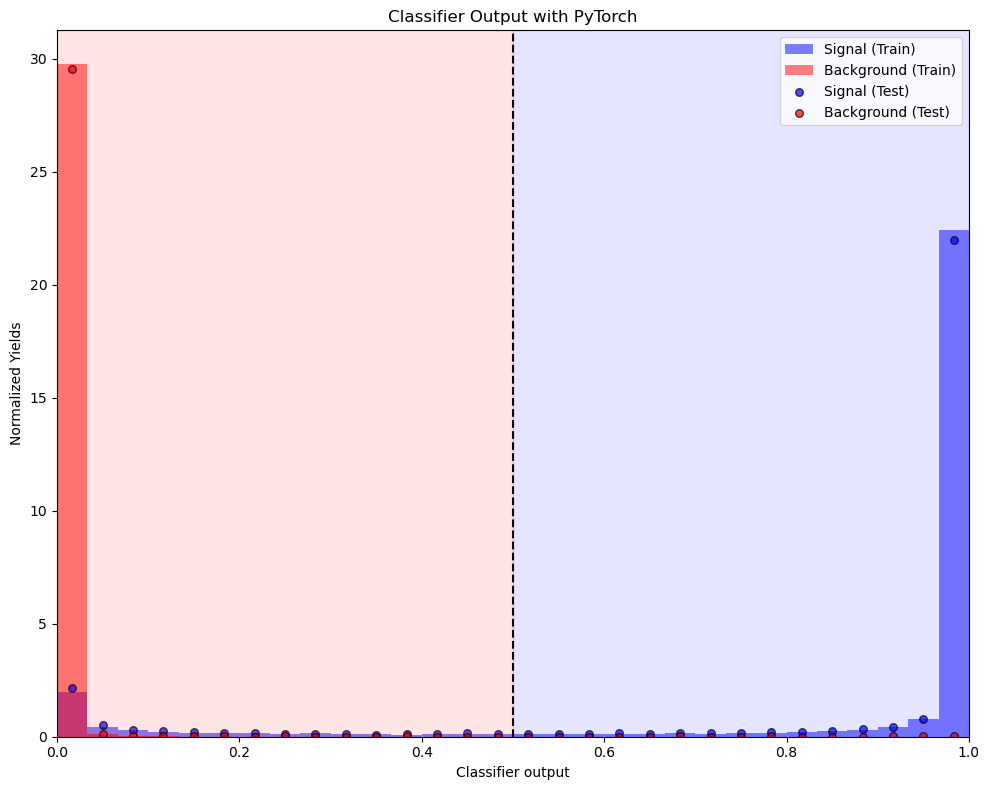

In [10]:
# Convert weights tensors to NumPy arrays
X_train_weights_np = X_train_weights_tensor.numpy()
X_test_weights_np = X_test_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)  

# Calculate histograms and bins for training data with weights
train_hist_s, _ = np.histogram(train_preds[train_true == 1], bins=bins, density=True, weights=X_train_weights_np[train_true == 1])
train_hist_b, _ = np.histogram(train_preds[train_true == 0], bins=bins, density=True, weights=X_train_weights_np[train_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for training data
plt.figure(figsize=(10, 8))
plt.hist(train_preds[train_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal (Train)', density=True, weights=X_train_weights_np[train_true == 1])
plt.hist(train_preds[train_true == 0], bins=bins, color='red', alpha=0.5, label='Background (Train)', density=True, weights=X_train_weights_np[train_true == 0])

# Calculate histograms for test data
test_hist_s, _ = np.histogram(test_preds[test_true == 1], bins=bins, density=True, weights=X_test_weights_np[test_true == 1])
test_hist_b, _ = np.histogram(test_preds[test_true == 0], bins=bins, density=True, weights=X_test_weights_np[test_true == 0])

# Plot scatter points for test data
plt.scatter(bin_centers, test_hist_s, color='blue', alpha=0.7, label='Signal (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output with PyTorch')

# Save and display the plot
# plt.savefig("../bdtplots/dnn/DNN_srbbgg_classifier_output_plot.png")
# plt.savefig("../bdtplots/dnn/DNN_srbbgg_classifier_output_plot.pdf")
plt.tight_layout()
plt.show()

# DNN Classifier plot for each dataset

In [ ]:
def load_data(files, keys):
    datasets = []
    for file, tree in files:
        with uproot.open(file) as f:
            tree = f[tree]
            features = tree.arrays(keys, library="np")
            data = np.column_stack([features[key] for key in keys if key != 'weight_preselection'])
            weights = features['weight_preselection']
            datasets.append((data, weights, file, tree))
    return datasets

In [ ]:
# Example dataset list
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/ttHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/VBFHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/VHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/Data_EraG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/Data_EraF/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/Data_EraE/preselection")
]

In [ ]:
# Load data
datasets = load_data(files, keys)


In [ ]:
# Define the model structure (same as the saved model)
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [ ]:
# Load the saved model
input_dim = len(keys) -1  # exclude the weight column
model = SimpleNN(input_dim=input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

In [ ]:
import torch
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = 29  # Correct the input dimension

# Assuming 'keys' is defined earlier in the notebook and contains the feature names
input_dim = len(keys) - 1  # exclude the weight column
print(f"Expected input dimension: {input_dim}")

# Load the saved model with the correct input dimension
model = SimpleNN(input_dim=input_dim)
try:
    model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
    print("Model loaded successfully")
except RuntimeError as e:
    print(f"Error loading model: {e}")
    print("Please ensure the input dimensions match the saved model's dimensions.")

model.eval()


In [ ]:
saved_state_dict = torch.load('preselection_simple_dnn_model.pth')
for k, v in saved_state_dict.items():
    print(f"{k}: {v.shape}")

In [ ]:

# Evaluate the model for each dataset
for data, weights, filename, treename in datasets:
    # Convert to PyTorch tensors
    X = torch.tensor(data, dtype=torch.float32)
    w = torch.tensor(weights, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(X, w)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # Collect predictions
    all_preds = []
    all_weights = []

    with torch.no_grad():
        for X_batch, w_batch in data_loader:
            outputs = model(X_batch).squeeze()
            all_preds.append(outputs.numpy())
            all_weights.append(w_batch.numpy())

    all_preds = np.concatenate(all_preds)
    all_weights = np.concatenate(all_weights)

    # Visualization
    bins = np.linspace(0, 1, 50)

    plt.figure(figsize=(10, 7))

    plt.hist(all_preds, bins=bins, color='blue', alpha=0.5, density=True, weights=all_weights)

    plt.axvspan(0, 0.5, color='red', alpha=0.1)
    plt.axvspan(0.5, 1, color='blue', alpha=0.1)

    plt.axvline(0.5, color='k', linestyle='--')
    plt.xlabel('Classifier output')
    plt.ylabel('Normalized Yields')
    plt.xlim(0, 1)
    plt.title(f'Classifier Output for {treename} in {filename}')

    plt.tight_layout()
    plt.show()


# Testing 

/home/shivam-raj/miniforge3/envs/hhbbgg-awk/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


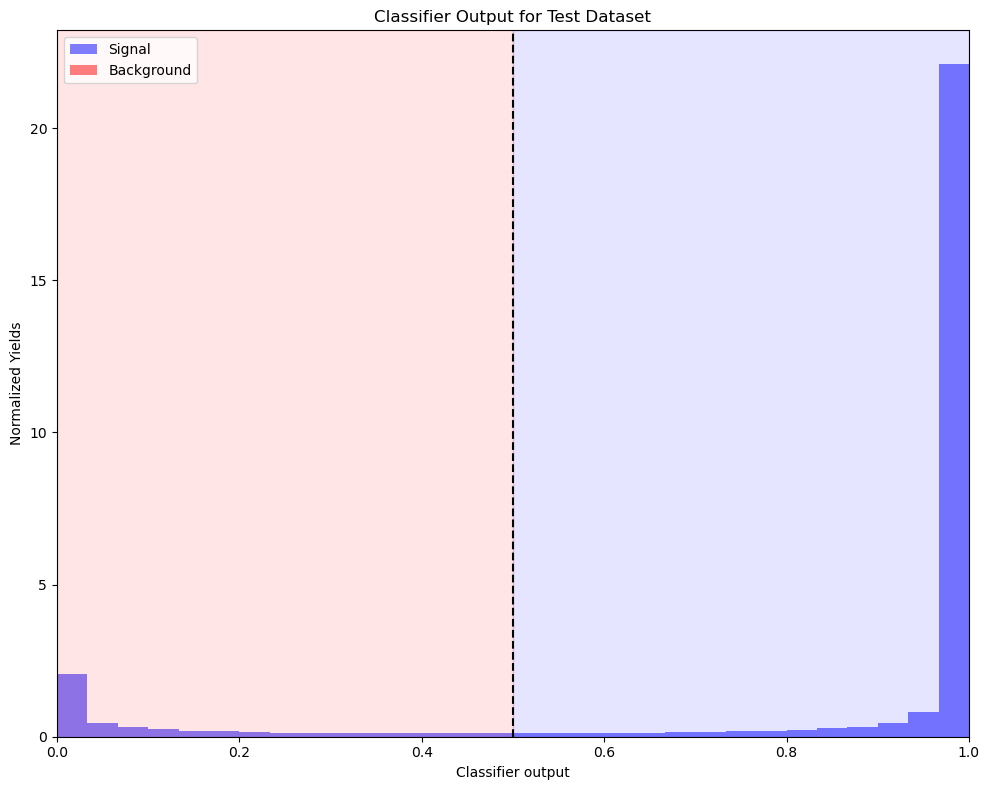

In [32]:
# Choose dataset to test
test_df = signal_df

# Prepare the data
X_test_single = test_df[features]
y_test_single = test_df['label']
weight_test_single = test_df['weight_preselection']

# Impute and scale the features
X_test_single_imputed = imputer.transform(X_test_single)
X_test_single_scaled = scaler.transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
y_test_single_tensor = torch.tensor(y_test_single.values, dtype=torch.long)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
single_test_data = TensorDataset(X_test_single_tensor, y_test_single_tensor, X_test_single_weights_tensor)
single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)

# Get predictions
single_test_preds, single_test_true = get_predictions(single_test_loader, model)

# Convert weights tensors to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for single test data with weights
hist_s, _ = np.histogram(single_test_preds[single_test_true == 1], bins=bins, density=True, weights=X_test_single_weights_np[single_test_true == 1])
hist_b, _ = np.histogram(single_test_preds[single_test_true == 0], bins=bins, density=True, weights=X_test_single_weights_np[single_test_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))
plt.hist(single_test_preds[single_test_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal', density=True, weights=X_test_single_weights_np[single_test_true == 1])
plt.hist(single_test_preds[single_test_true == 0], bins=bins, color='red', alpha=0.5, label='Background', density=True, weights=X_test_single_weights_np[single_test_true == 0])

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
# plt.savefig("classifier_output_test_dataset.png")
plt.tight_layout()
plt.show()


## Testing 

In [42]:
# Example dataset list
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/ttHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/VBFHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/VHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluHToGG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/Data_EraG/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/Data_EraF/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/Data_EraE/preselection")
]

In [46]:
dfs = {}

for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(keys, library="pd")
        
ttH_file = dfs["/ttHToGG/preselection"]

In [47]:
ttH_file

,bbgg_mass,dibjet_pt,diphoton_pt,bbgg_pt,bbgg_eta,bbgg_phi,lead_pho_eta,lead_pho_phi,sublead_pho_eta,sublead_pho_phi,...,CosThetaStar_jj,CosThetaStar_CS,DeltaR_jg_min,pholead_PtOverM,phosublead_PtOverM,FirstJet_PtOverM,SecondJet_PtOverM,diphoton_bbgg_mass,dibjet_bbgg_mass,weight_preselection
0,313.232779,87.122403,237.430230,318.973687,1.175774,1.680849,0.595337,1.565674,1.595947,1.573486,...,0.317935,0.884864,0.530408,1.023637,0.898179,0.618451,0.498737,0.757999,0.278139,0.000148
1,395.446576,65.170405,107.394663,84.965529,3.071064,-1.081658,0.612793,-0.947144,1.272461,0.806641,...,0.056020,-0.782860,1.779845,0.823525,0.431348,0.588238,0.519969,0.271578,0.164802,0.000148
2,324.267939,250.544932,53.079437,292.592375,-1.119357,-2.391572,-0.645630,2.409180,-0.285095,-1.499268,...,-0.580293,0.851015,0.662895,0.600894,0.465951,1.728100,0.273218,0.163690,0.772648,0.000148
3,316.664438,60.233173,69.206512,74.542039,-2.529958,-1.765643,-1.125977,-0.370789,-1.673584,-2.723633,...,0.647629,-0.438185,1.179877,0.716280,0.375608,0.442648,0.373701,0.218548,0.190211,0.000148
4,338.370782,173.549633,154.118378,241.642984,0.074470,-0.440316,0.237061,-1.799805,0.341248,-0.401855,...,-0.989517,0.391250,0.676310,0.913990,0.656375,1.027696,0.564889,0.455472,0.512898,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271316,333.440742,126.741727,173.741665,203.743211,0.520751,-2.635326,0.235779,-2.213379,-0.640381,-0.910400,...,0.360599,-0.393977,1.292110,1.253320,0.348605,1.308521,0.277078,0.521057,0.380103,-0.000148
271317,465.040505,51.810069,356.322059,311.245669,0.104575,2.426089,0.255188,2.610352,0.283447,1.913330,...,0.063571,0.453086,1.268201,1.871612,1.143413,0.665819,0.378784,0.766217,0.111410,0.000148
271318,273.010010,36.816524,100.161734,79.155157,1.830224,2.956358,0.617310,-2.983398,1.170898,1.542725,...,-0.557602,0.355688,0.604613,0.719262,0.517856,0.550477,0.263682,0.366879,0.134854,0.000148
271319,402.030426,114.418887,172.502084,59.649894,-2.778713,-0.243344,-0.960693,0.072128,-2.094727,-0.282288,...,-0.213024,-0.582968,0.867512,1.056155,0.609207,1.086919,0.242370,0.429077,0.284603,0.000148


In [49]:
# Prepare the data
X_test_single = ttH_file[features]
# y_test_single = test_df['label']
weight_test_single = ttH_file['weight_preselection']


In [50]:

# Impute and scale the features
X_test_single_imputed = imputer.transform(X_test_single)
X_test_single_scaled = scaler.transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
# y_test_single_tensor = torch.tensor(y_test_single.values, dtype=torch.long)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
single_test_data = TensorDataset(X_test_single_tensor, X_test_single_weights_tensor)
single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)

# Get predictions
single_test_preds, single_test_true = get_predictions(single_test_loader, model)

# Convert weights tensors to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)


/home/shivam-raj/miniforge3/envs/hhbbgg-awk/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


ValueError: The 'color' keyword argument must have one color per dataset, but 271321 datasets and 1 colors were provided

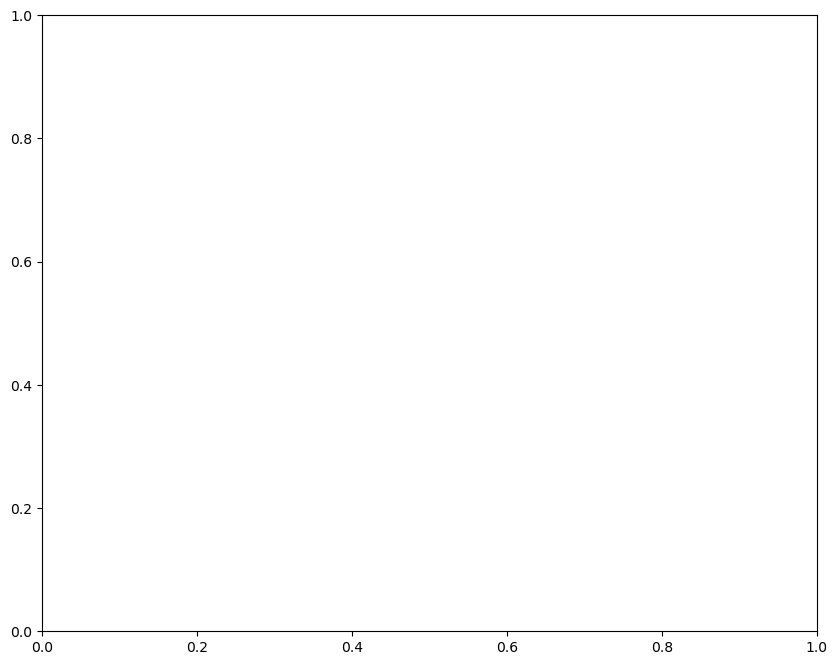

In [51]:

# Calculate histograms and bins for single test data with weights
hist_s, _ = np.histogram(single_test_preds[single_test_true == 1], bins=bins, density=True, weights=X_test_single_weights_np[single_test_true == 1])
hist_b, _ = np.histogram(single_test_preds[single_test_true == 0], bins=bins, density=True, weights=X_test_single_weights_np[single_test_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))
plt.hist(single_test_preds[single_test_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal', density=True, weights=X_test_single_weights_np[single_test_true == 1])
plt.hist(single_test_preds[single_test_true == 0], bins=bins, color='red', alpha=0.5, label='Background', density=True, weights=X_test_single_weights_np[single_test_true == 0])

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
# plt.savefig("classifier_output_test_dataset.png")
plt.tight_layout()
plt.show()

Label column is missing in the dataset


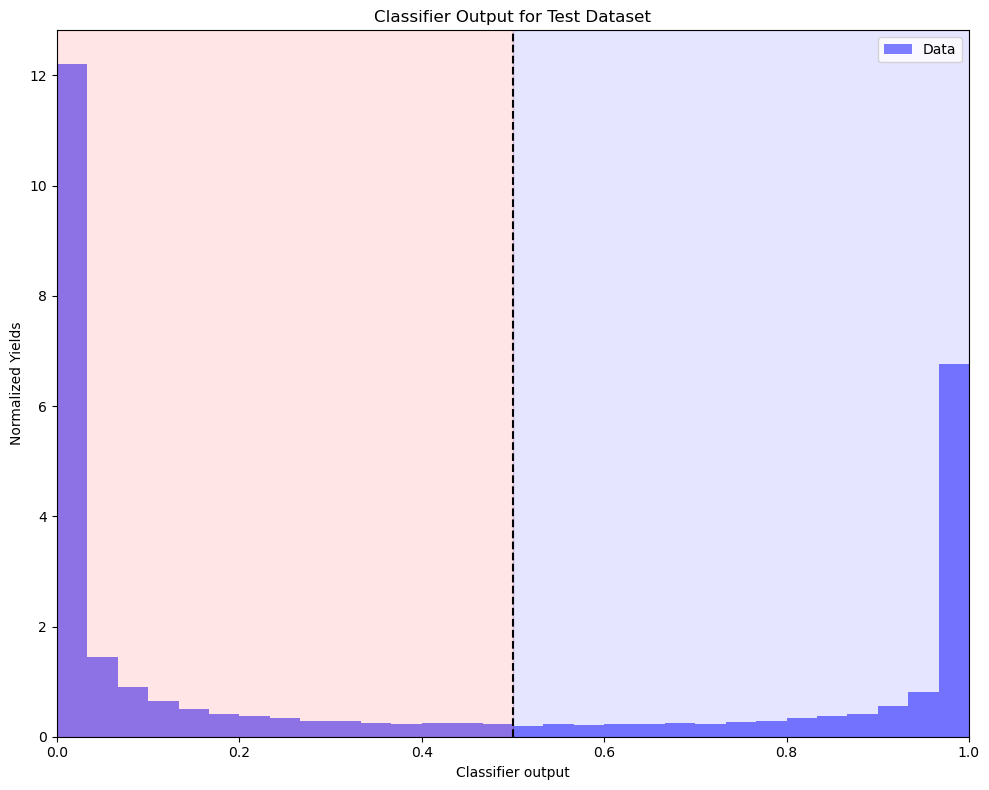

In [53]:
import pandas as pd
import uproot
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

# Define the file and key
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/ttHToGG/preselection")
]
dfs = {}

# Load the data
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(library="pd")

# Extract the dataframe for the specific key
ttH_file = dfs["/ttHToGG/preselection"]

# Define features and weight column
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta',
    'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg',
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 'FirstJet_PtOverM',
    'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'
]

# Prepare the data
X_test_single = ttH_file[features]
weight_test_single = ttH_file['weight_preselection']

# Check if the label column is present
if 'label' in ttH_file.columns:
    y_test_single = ttH_file['label']
else:
    y_test_single = None
    print("Label column is missing in the dataset")

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_test_single_imputed = imputer.fit_transform(X_test_single)
scaler = StandardScaler()
X_test_single_scaled = scaler.fit_transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
if y_test_single is not None:
    y_test_single_tensor = torch.tensor(y_test_single.values, dtype=torch.long)
    single_test_data = TensorDataset(X_test_single_tensor, y_test_single_tensor, X_test_single_weights_tensor)
else:
    single_test_data = TensorDataset(X_test_single_tensor, X_test_single_weights_tensor)

single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)

# Define the model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model and load the saved weights
input_dim = X_test_single_scaled.shape[1]
model = SimpleDNN(input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:  # If there are labels and weights
                inputs, labels, _ = batch
            else:  # If there are only inputs and weights
                inputs, _ = batch
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
    return np.array(all_preds)

# Get predictions for single test data
single_test_preds = get_predictions(single_test_loader, model)

# Convert weights tensor to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for single test data with weights
hist, _ = np.histogram(single_test_preds, bins=bins, density=True, weights=X_test_single_weights_np)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))
plt.hist(single_test_preds, bins=bins, color='blue', alpha=0.5, label='Data', density=True, weights=X_test_single_weights_np)

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
plt.tight_layout()
plt.show()


Label column is missing in the dataset


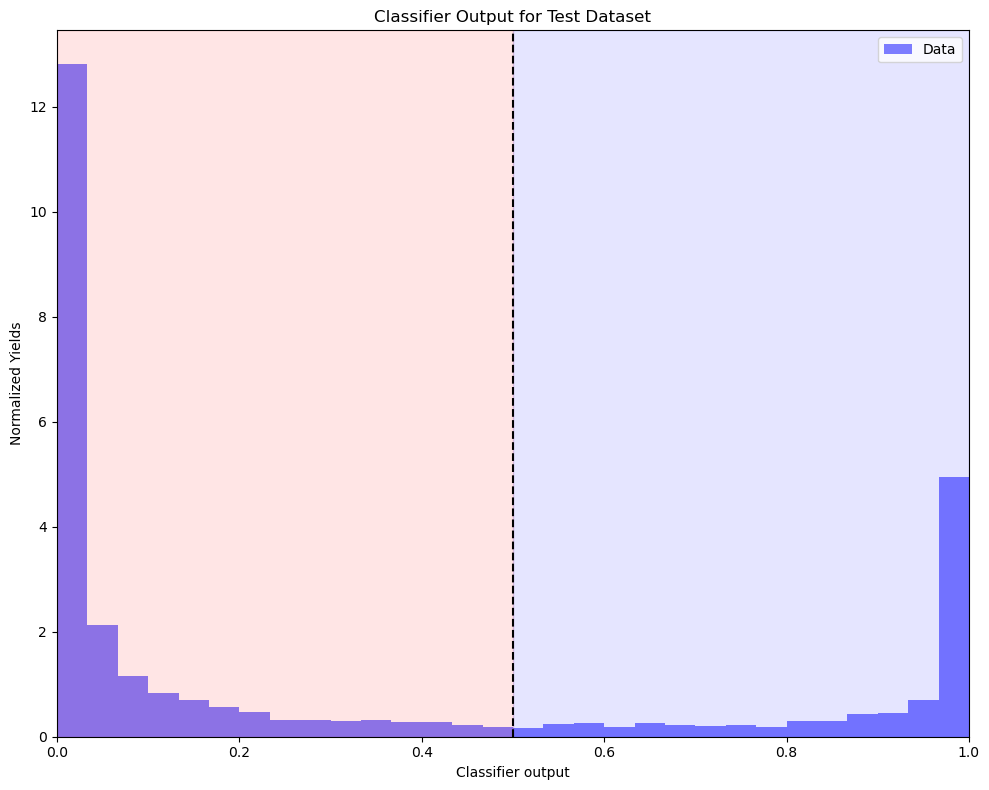

In [55]:
import pandas as pd
import uproot
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

# Define the file and key
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/VBFHToGG/preselection")
]
dfs = {}

# Load the data
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(library="pd")

# Extract the dataframe for the specific key
ttH_file = dfs["/VBFHToGG/preselection"]

# Define features and weight column
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta',
    'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg',
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 'FirstJet_PtOverM',
    'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'
]

# Prepare the data
X_test_single = ttH_file[features]
weight_test_single = ttH_file['weight_preselection']

# Check if the label column is present
if 'label' in ttH_file.columns:
    y_test_single = ttH_file['label']
else:
    y_test_single = None
    print("Label column is missing in the dataset")

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_test_single_imputed = imputer.fit_transform(X_test_single)
scaler = StandardScaler()
X_test_single_scaled = scaler.fit_transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
if y_test_single is not None:
    y_test_single_tensor = torch.tensor(y_test_single.values, dtype=torch.long)
    single_test_data = TensorDataset(X_test_single_tensor, y_test_single_tensor, X_test_single_weights_tensor)
else:
    single_test_data = TensorDataset(X_test_single_tensor, X_test_single_weights_tensor)

single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)

# Define the model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model and load the saved weights
input_dim = X_test_single_scaled.shape[1]
model = SimpleDNN(input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:  # If there are labels and weights
                inputs, labels, _ = batch
            else:  # If there are only inputs and weights
                inputs, _ = batch
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
    return np.array(all_preds)

# Get predictions for single test data
single_test_preds = get_predictions(single_test_loader, model)

# Convert weights tensor to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for single test data with weights
hist, _ = np.histogram(single_test_preds, bins=bins, density=True, weights=X_test_single_weights_np)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))
plt.hist(single_test_preds, bins=bins, color='blue', alpha=0.5, label='Data', density=True, weights=X_test_single_weights_np)

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
plt.tight_layout()
plt.show()


Label column is missing in the dataset


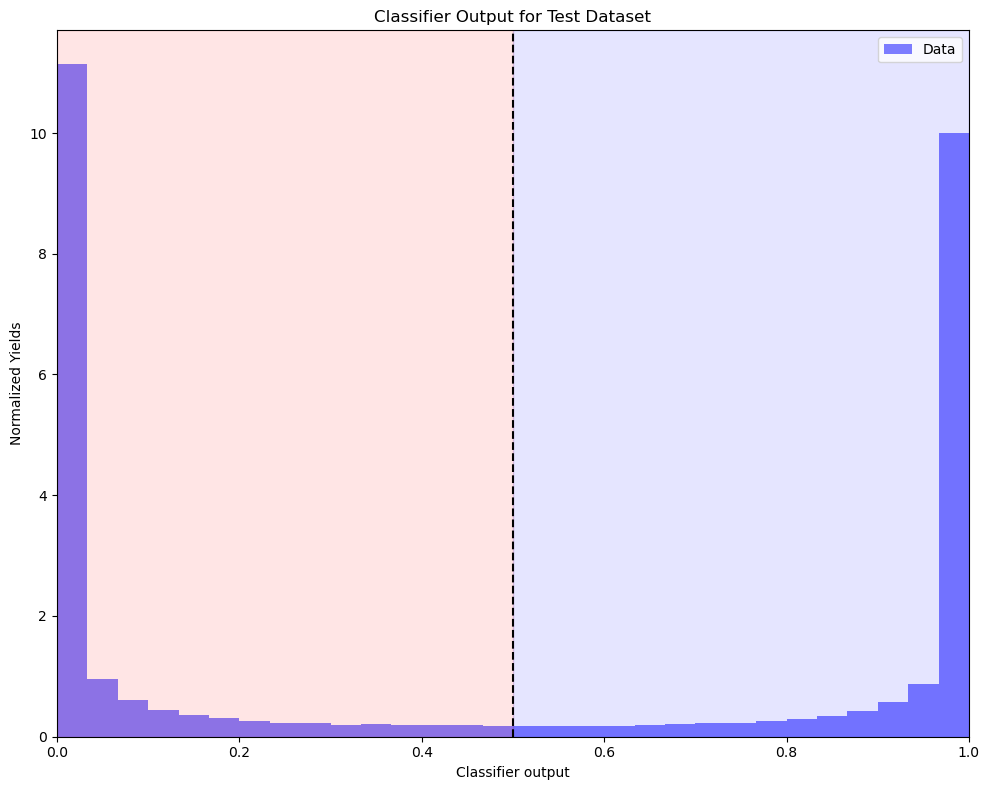

In [63]:
import pandas as pd
import uproot
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

# Define the file and key
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection")
]
dfs = {}

# Load the data
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(library="pd")

# Extract the dataframe for the specific key
ttH_file = dfs["/GluGluToHH/preselection"]

# Define features and weight column
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta',
    'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg',
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 'FirstJet_PtOverM',
    'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'
]

# Prepare the data
X_test_single = ttH_file[features]
weight_test_single = ttH_file['weight_preselection']

# Check if the label column is present
if 'label' in ttH_file.columns:
    y_test_single = ttH_file['label']
else:
    y_test_single = None
    print("Label column is missing in the dataset")

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_test_single_imputed = imputer.fit_transform(X_test_single)
scaler = StandardScaler()
X_test_single_scaled = scaler.fit_transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
if y_test_single is not None:
    y_test_single_tensor = torch.tensor(y_test_single.values, dtype=torch.long)
    single_test_data = TensorDataset(X_test_single_tensor, y_test_single_tensor, X_test_single_weights_tensor)
else:
    single_test_data = TensorDataset(X_test_single_tensor, X_test_single_weights_tensor)

single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)

# Define the model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model and load the saved weights
input_dim = X_test_single_scaled.shape[1]
model = SimpleDNN(input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:  # If there are labels and weights
                inputs, labels, _ = batch
            else:  # If there are only inputs and weights
                inputs, _ = batch
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
    return np.array(all_preds)

# Get predictions for single test data
single_test_preds = get_predictions(single_test_loader, model)

# Convert weights tensor to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for single test data with weights
hist, _ = np.histogram(single_test_preds, bins=bins, density=True, weights=X_test_single_weights_np)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))
plt.hist(single_test_preds, bins=bins, color='blue', alpha=0.5, label='Data', density=True, weights=X_test_single_weights_np)

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
plt.tight_layout()
plt.show()


In [68]:
import pandas as pd
import uproot
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

# Define the file and key
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection")
]
dfs = {}

# Load the data
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(library="pd")

# Extract the dataframe for the specific key
data_file = dfs["/GluGluToHH/preselection"]

# Define features and weight column
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta',
    'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg',
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 'FirstJet_PtOverM',
    'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'
]

# Prepare the data
X_test_single = data_file[features]
weight_test_single = data_file['weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_test_single_imputed = imputer.fit_transform(X_test_single)
scaler = StandardScaler()
X_test_single_scaled = scaler.fit_transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
single_test_data = TensorDataset(X_test_single_tensor, X_test_single_weights_tensor)
single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)


In [69]:
# Define the model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model and load the saved weights
input_dim = X_test_single_scaled.shape[1]
model = SimpleDNN(input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()


SimpleDNN(
  (fc1): Linear(in_features=29, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

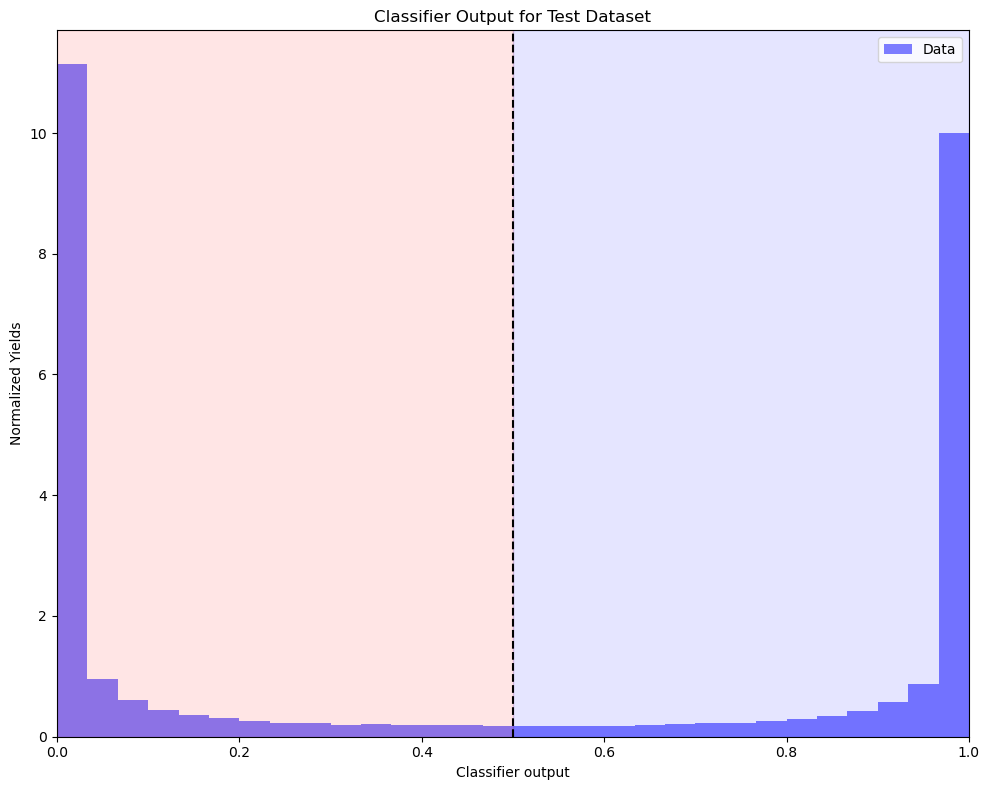

In [70]:
# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            inputs, _ = batch
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
    return np.array(all_preds)

# Get predictions for single test data
single_test_preds = get_predictions(single_test_loader, model)

# Convert weights tensor to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for single test data with weights
hist, _ = np.histogram(single_test_preds, bins=bins, density=True, weights=X_test_single_weights_np)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))
plt.hist(single_test_preds, bins=bins, color='blue', alpha=0.5, label='Data', density=True, weights=X_test_single_weights_np)

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
plt.tight_layout()
plt.show()


Label column is missing in the dataset


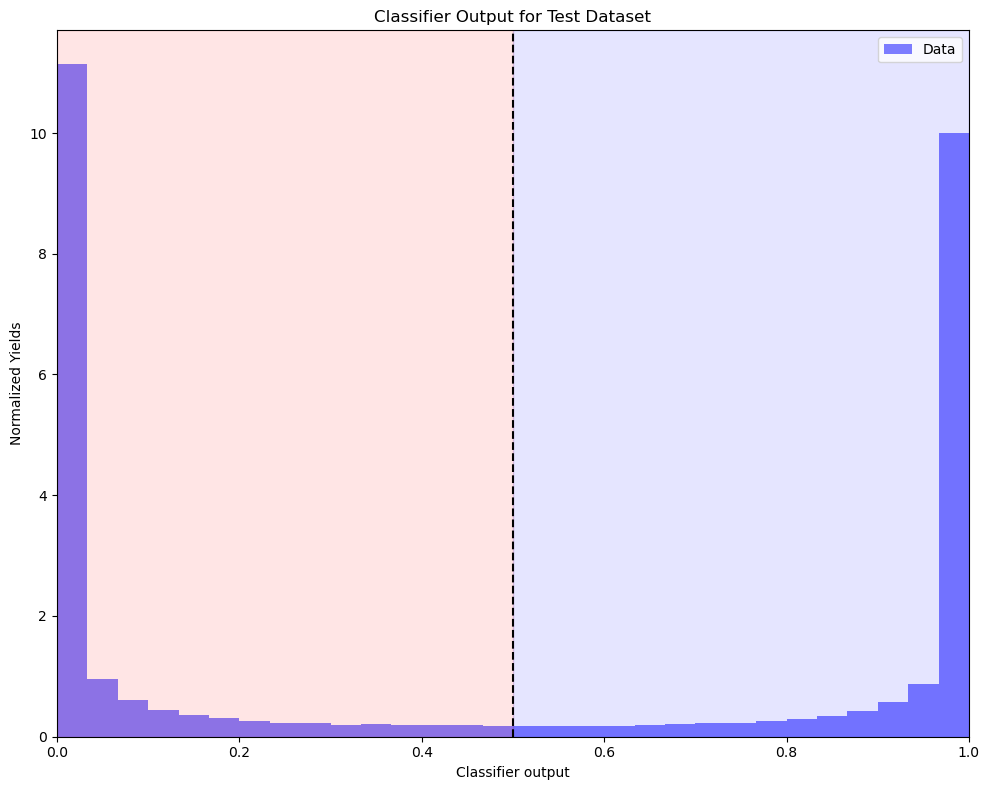

In [72]:
import pandas as pd
import uproot
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

# Define the file and key
files = [
    ("../../outputfiles/hhbbgg_analyzer-trees.root", "/GluGluToHH/preselection")
]
dfs = {}

# Load the data
for file, key in files:
    with uproot.open(file) as f:
        dfs[key] = f[key].arrays(library="pd")

# Extract the dataframe for the specific key
data_file = dfs["/GluGluToHH/preselection"]

# Define features and weight column
features = [
    'bbgg_eta', 'bbgg_phi', 'bbgg_mass', 'lead_pho_eta', 'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta',
    'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg',
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 'phosublead_PtOverM', 'FirstJet_PtOverM',
    'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'
]

# Prepare the data
X_test_single = data_file[features]
weight_test_single = data_file['weight_preselection']

# Check if the label column is present
if 'label' in data_file.columns:
    y_test_single = data_file['label']
else:
    y_test_single = None
    print("Label column is missing in the dataset")

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_test_single_imputed = imputer.fit_transform(X_test_single)
scaler = StandardScaler()
X_test_single_scaled = scaler.fit_transform(X_test_single_imputed)

# Convert to torch tensors
X_test_single_tensor = torch.tensor(X_test_single_scaled, dtype=torch.float32)
X_test_single_weights_tensor = torch.tensor(weight_test_single.values, dtype=torch.float32)

# Create DataLoader
if y_test_single is not None:
    y_test_single_tensor = torch.tensor(y_test_single.values, dtype=torch.long)
    single_test_data = TensorDataset(X_test_single_tensor, y_test_single_tensor, X_test_single_weights_tensor)
else:
    single_test_data = TensorDataset(X_test_single_tensor, X_test_single_weights_tensor)

single_test_loader = DataLoader(single_test_data, batch_size=32, shuffle=False)

# Define the model
class SimpleDNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model and load the saved weights
input_dim = X_test_single_scaled.shape[1]
model = SimpleDNN(input_dim)
model.load_state_dict(torch.load('preselection_simple_dnn_model.pth'))
model.eval()

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:  # If there are labels and weights
                inputs, labels, _ = batch
                all_labels.extend(labels.cpu().numpy())
            else:  # If there are only inputs and weights
                inputs, _ = batch
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for single test data
single_test_preds, single_test_true = get_predictions(single_test_loader, model)

# Convert weights tensor to NumPy arrays
X_test_single_weights_np = X_test_single_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Calculate histograms and bins for single test data with weights
if y_test_single is not None:
    hist_s, _ = np.histogram(single_test_preds[single_test_true == 1], bins=bins, density=True, weights=X_test_single_weights_np[single_test_true == 1])
    hist_b, _ = np.histogram(single_test_preds[single_test_true == 0], bins=bins, density=True, weights=X_test_single_weights_np[single_test_true == 0])
else:
    hist, _ = np.histogram(single_test_preds, bins=bins, density=True, weights=X_test_single_weights_np)

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for single test data
plt.figure(figsize=(10, 8))

if y_test_single is not None:
    plt.hist(single_test_preds[single_test_true == 1], bins=bins, color='blue', alpha=0.5, label='Signal', density=True, weights=X_test_single_weights_np[single_test_true == 1])
    plt.hist(single_test_preds[single_test_true == 0], bins=bins, color='red', alpha=0.5, label='Background', density=True, weights=X_test_single_weights_np[single_test_true == 0])
else:
    plt.hist(single_test_preds, bins=bins, color='blue', alpha=0.5, label='Data', density=True, weights=X_test_single_weights_np)

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output for Test Dataset')

# Save and display the plot
plt.tight_layout()
plt.show()
